# Data Science at IGFAE 2024
## Lesson 2

## Pietro Vischia (Universidad de Oviedo and ICTEA), pietro.vischia@cern.ch

In [1]:
# Uncomment and run this if you are running on Colab (remove only the "#", keep the "!").
# You can run it anyway, but it will do nothing if you have already installed all dependencies
# (and it will take some time to tell you it is not gonna do anything)


#from google.colab import drive
#drive.mount('/content/drive')
#%cd "/content/drive/MyDrive/"
#! git clone https://github.com/vischia/data_science_school_igfae2024.git
#%cd machine_learning_tutorial
#!pwd
#!ls
#!pip install livelossplot shap uproot

In [196]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
import re
import math
import socket
import json
import pickle
import gzip
import copy
import array
import numpy as np
import numpy.lib.recfunctions as recfunc

from scipy.optimize import newton
from scipy.stats import norm

import uproot

import datetime
from timeit import default_timer as timer

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
try:
    # See #1137: this allows compatibility for scikit-learn >= 0.24
    from sklearn.utils import safe_indexing
except ImportError:
    from sklearn.utils import _safe_indexing

import pandas as pd


In [197]:
!pip install torch torchinfo
import torchinfo
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn.functional as F

Let's briefly see how `torch`deals with gradients

Let's calculate gradients of a simple equation using autodiff

In [237]:
x0 = torch.tensor(1., requires_grad=True)
x1 = torch.tensor(2., requires_grad=True)
p = 2*x0 + x0*torch.sin(x1) + x1**3
print(p)
p.backward()
print(x0.grad, x1.grad)


tensor(10.9093, grad_fn=<AddBackward0>)
tensor(2.9093) tensor(11.5839)


The importance of using operations that have been overloaded within the library: implement the same equation, but this time the function `sin` is imported from `math`.

Notice how no error message is thrown, but gradients are completely different. This is because `torch`is blind to the portion of equation involving `math.sin`, in the sense that it cannot anymore propagate the gradient through it.

In [236]:
x0 = torch.tensor(1., requires_grad=True)
x1 = torch.tensor(2., requires_grad=True)
p = 2*x0 + x0*math.sin(x1) + x1**3
print(p)
p.backward()
print(x0.grad, x1.grad)

tensor(10.9093, grad_fn=<AddBackward0>)
tensor(2.9093) tensor(12.)


Now let's plot some activation function.

Let's also plot the derivative of each activation function, in two ways: by plotting the explicitly coded derivative function, and by plotting the derivative computed via automatic differentiation, `x.grad`.

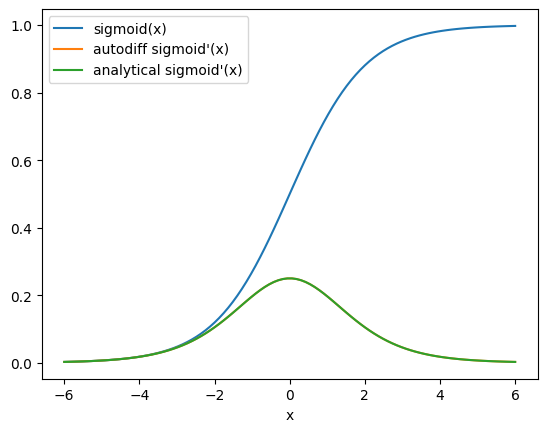

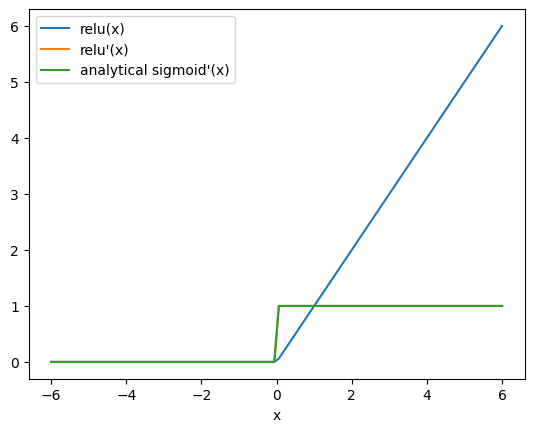

In [214]:
x = torch.tensor(np.linspace(-6, 6, 100), requires_grad=True)
y =torch.sigmoid(x)
yprime = lambda x: torch.sigmoid(x)*(1-torch.sigmoid(x))

func, =plt.plot(x.detach().numpy(),y.detach().numpy(), label="sigmoid(x)")
plt.xlabel("x")
Y = torch.sum(y)
Y.backward()
derivative, =plt.plot(x.detach().numpy(),x.grad.detach().numpy(), label="autodiff sigmoid'(x)")
anal_derivative = plt.plot(x.detach().numpy(), yprime(x).detach().numpy(), label="analytical sigmoid'(x)")

plt.legend()
plt.savefig("figs/sigmoid.png")
plt.figure()
x = torch.tensor(np.linspace(-6, 6, 100), requires_grad=True)
y =torch.relu(x)
yprime = lambda x: torch.where(x>0, 1,0) 

func, =plt.plot(x.detach().numpy(),y.detach().numpy(), label="relu(x)")
plt.xlabel("x")
Y = torch.sum(y)
Y.backward()
derivative, =plt.plot(x.detach().numpy(),x.grad.detach().numpy(), label="relu'(x)")
anal_derivative = plt.plot(x.detach().numpy(), yprime(x).detach().numpy(), label="analytical sigmoid'(x)")
plt.legend()
plt.savefig("figs/relu.png")

# Import data

We will use simulated events corresponding to three physics processes.

- ttH production
- ttW production
- Drell-Yan production

We will select the multilepton final state, which is a challenging final state with a rich structure and nontrivial background separation.

<img src="figs/2lss.png" alt="ttH multilepton 2lss" style="width:40%;"/>


In [3]:
INPUT_FOLDER = './'
HAVE_GPU = True
# Uncomment this if you haven't installed the data yet
#!cd data/; wget https://www.hep.uniovi.es/vischia/cmsdas2024/ft_tth_multilep_igfae2024.tar.gz; tar xzvf ft_tth_multilep_igfae2024.tar.gz; mv igfae2024/* .; rmdir igfae2024; rm ft_tth_multilep_igfae2024.tar.gz; cd -;

In [180]:
import uproot
sig = uproot.open('data/signal.root')['Friends'].arrays(library="pd")
bk1 = uproot.open('data/background_1.root')['Friends'].arrays(library="pd")
bk2 = uproot.open('data/background_2.root')['Friends'].arrays(library="pd")


## Data inspection

We will now apply in one go all the manipulations of the input dataset that we have seen yesterday

First we drop all features that either correspond to unwanted objects (third lepton) or to labels we will need later on for regression.

In [181]:
signal = sig.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag", "Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y"], axis=1 )
bkg1 = bk1.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag","Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y"], axis=1 )
bkg2 = bk2.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag","Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y"], axis=1 )


Now we add the labels for classification...

In [182]:
signal['label'] = 1
bkg = pd.concat([bkg1, bkg2])
bkg['label'] = 0
data = pd.concat([signal,bkg]).sample(frac=1).reset_index(drop=True)
X = data.drop(["label"], axis=1)
y = data["label"]

and we split the data into training and test dataset.
Let's also go straight to the downsampling (you can run on your own on the whole training dataset, but for this demonstration we don't need to do that).

In [183]:
import sklearn
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)
print("We have", len(X_train), "training samples and ", len(X_test), "testing samples")

Ntrain=10000
Ntest=2000
X_train = X_train[:Ntrain]
y_train = y_train[:Ntrain]
X_test = X_test[:Ntest]
y_test = y_test[:Ntest]

# LABEL OF THIS PLACE HERE, WILL BE USEFUL LATER

We have 1266862 training samples and  623977 testing samples


For neural networks we will use `pytorch`, a backend designed natively for tensor operations.
I prefer it to tensorflow, because it exposes (i.e. you have to call them explicitly in your code) the optimizer steps and the backpropagation steps.

You could also use the `tensorflow` backend, either directly or through the `keras` frontend.
Saying "I use keras" does not tell you which backend is being used. It used to be either `tensorflow` or `theano`. Nowadays `keras` is I think almost embedded inside tensorflow, but it is still good to specify.

In [186]:
def plot_rocs(scores_and_names, y):
    pack=[] 
    for s, n in scores_and_names: 
        fpr, tpr, thresholds = roc_curve(y.ravel(), s)
        pack.append([n, fpr,tpr,thresholds])

    plt.figure()
    lw=2
    for n, fpr, tpr, thresholds in pack:
        plt.plot(fpr, tpr, lw=lw, label="%s (AUC = %0.2f)" % (n, auc(fpr, tpr))) 

    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic curve")
    plt.legend(loc="lower right")
    plt.show()

    
#y_score = fitted_bdt_ada.decision_function(X_test)
#plot_rocs([ [fitted_bdt_ada.decision_function(X_test), 'AdaBoost'],
#            [fitted_bdt_grad.decision_function(X_test), 'GradBoost']],
#          y_test)

`torch` handles the data management via the `Dataset` and `DataLoader` classes.
Here we don't need any specific `Dataset` class, because we are not doing sophisticated things, but you may need that in the future.

The `Dataloader` class takes care of providing quick access to the data by sampling batches that are then fed to the network for (mini)batch gradient descent.

In [187]:
class MyDataset(Dataset):
    def __init__(self, X, y, device=torch.device("cpu")):
        self.X = torch.Tensor(X.values if isinstance(X, pd.core.frame.DataFrame) else X).to(device)
        self.y = torch.Tensor(y.values).to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        label = self.y[idx]
        datum = self.X[idx]
        
        return datum, label

batch_size=512 # Minibatch learning


train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


Feature batch shape: torch.Size([512, 27])
Labels batch shape: torch.Size([512])


For educational purposes, let's get access the data loader via its iterator, and sample a single batch by calling `next` on the iterator

In [188]:
random_batch_X, random_batch_y = next(iter(train_dataloader))
print(random_batch_X.shape, random_batch_y.shape) 

torch.Size([512, 27]) torch.Size([512])


Let's build a simple neural network, by inheriting from the `nn.Module` class. **This is very crucial, because that class is the responsible for providing the automatic differentiation infrastructure for tracking parameters and doing backpropagation**

In [189]:
class NeuralNetwork(nn.Module):
    def __init__(self, ninputs, device=torch.device("cpu")):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(ninputs, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,8),
            nn.Sigmoid(),
            nn.Linear(8, 1)
        )
        self.linear_relu_stack.to(device)

    def forward(self, x):
        # Pass data through conv1
        x = self.linear_relu_stack(x)
        return x

Let's instantiate the neural network and print some info on it

In [190]:
model = NeuralNetwork(X_train.shape[1])

print(model) # some basic info

print("Now let's see some more detailed info by using the torchinfo package")
torchinfo.summary(model, input_size=(batch_size, X_train.shape[1])) # the input size is (batch size, number of features)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=27, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=8, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)
Now let's see some more detailed info by using the torchinfo package


Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [512, 1]                  --
├─Sequential: 1-1                        [512, 1]                  --
│    └─Linear: 2-1                       [512, 512]                14,336
│    └─ReLU: 2-2                         [512, 512]                --
│    └─Linear: 2-3                       [512, 128]                65,664
│    └─ReLU: 2-4                         [512, 128]                --
│    └─Linear: 2-5                       [512, 64]                 8,256
│    └─ReLU: 2-6                         [512, 64]                 --
│    └─Linear: 2-7                       [512, 8]                  520
│    └─Sigmoid: 2-8                      [512, 8]                  --
│    └─Linear: 2-9                       [512, 1]                  9
Total params: 88,785
Trainable params: 88,785
Non-trainable params: 0
Total mult-adds (M): 45.46
Input size (MB): 0.06
Forward/backward pass siz

Now let's introduce a crucial concept: `torch` lets you manage in which device you want to put your data and models, to optimize access at different stages

In [191]:
devicestring = "mps" # for macos. "cuda" for CUDA gpus, "cpu" for CPUs

device = torch.device("cuda:0" if torch.cuda.is_available() else devicestring)


# Get a batch from the dataloader
random_batch_X, random_batch_y = next(iter(train_dataloader))

print("The original dataloader resides in", random_batch_X.get_device())

# Let's reinstantiate the dataset
train_dataset = MyDataset(X_train, y_train, device=device)
test_dataset = MyDataset(X_test, y_test, device=device)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

random_batch_X, random_batch_y = next(iter(train_dataloader))

print("The new dataloader puts the batches in in", random_batch_X.get_device())

# Reinstantiate the model, on the chosen device
model = NeuralNetwork(X_train.shape[1], device)


The original dataloader resides in -1
The new dataloader puts the batches in in 0


We have learned how load the data into the GPU, how to define and instantiate a model. Now we need to define a training loop.

In `keras`, this is wrapped hidden into the `.fit()` method, which I think is bad because it hides the actual procedure.

In [192]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler, device):
    size = len(dataloader.dataset)
    losses=[] # Track the loss function
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Reset gradients (to avoid their accumulation)
        optimizer.zero_grad()
        # Compute prediction and loss
        pred = model(X)
        #if (all_equal3(pred.detach().numpy())):
        #    print("All equal!")
        loss = loss_fn(pred.squeeze(dim=1), y)
        losses.append(loss.detach().cpu())
        # Backpropagation
        loss.backward()
        optimizer.step()

    scheduler.step()
    return np.mean(losses)

Now we need to define the loop that is run on the test dataset.

**The test dataset is just used for evaluating the output of the model. No backpropagation is needed, therefore backpropagation must be switched off!!!**

In [193]:
def test_loop(dataloader, model, loss_fn, device):
    losses=[] # Track the loss function
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss = loss_fn(pred.squeeze(dim=1), y).item()
            losses.append(loss)
            test_loss += loss
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    return np.mean(losses)

We are now read to train this!
At the moment we are trying to do classification. We will set our loss function to be the cross entropy.

Torch provides the functionality to use generic functions as loss function. We will show an example one.

In [194]:

#loss_fn = torch.nn.MSELoss()
loss_fn = torch.nn.CrossEntropyLoss()

#loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
def CPloss(y_hat,y):
    loss = torch.mean( y[:,0]*torch.pow( y_hat - y[:,1], 2))
    #quad=-1,2
    #lin=-2,1
    #sm=-3,0
    return loss
# We would use this loss function in the same way as the other predefined loss functions:
# loss_fn=CPloss


Time to define optimizer and scheduler, number of epochs, and finally to train!

Epoch 1
-------------------------------
Avg train loss 477.63013 , Avg test loss 491.1049499511719 Current learning rate [0.009000000000000001]
Epoch 2
-------------------------------
Avg train loss 478.36725 , Avg test loss 491.0557174682617 Current learning rate [0.008100000000000001]
Epoch 3
-------------------------------
Avg train loss 478.27237 , Avg test loss 491.2771987915039 Current learning rate [0.007290000000000001]
Epoch 4
-------------------------------
Avg train loss 478.14584 , Avg test loss 491.03112030029297 Current learning rate [0.006561000000000002]
Epoch 5
-------------------------------
Avg train loss 478.24078 , Avg test loss 490.88343811035156 Current learning rate [0.005904900000000002]
Epoch 6
-------------------------------
Avg train loss 478.36725 , Avg test loss 490.9326705932617 Current learning rate [0.005314410000000002]
Epoch 7
-------------------------------
Avg train loss 478.01935 , Avg test loss 491.22801208496094 Current learning rate [0.004782969

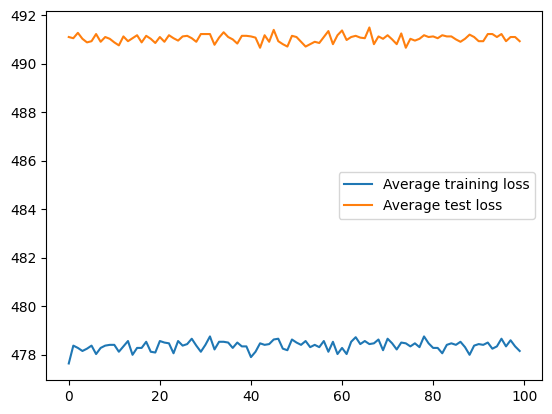

In [195]:
epochs=100
learningRate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

train_losses=[]
test_losses=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss=train_loop(train_dataloader, model, loss_fn, optimizer, scheduler, device)
    test_loss=test_loop(test_dataloader, model, loss_fn, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print("Avg train loss", train_loss, ", Avg test loss", test_loss, "Current learning rate", scheduler.get_last_lr())
print("Done!")


plt.plot(train_losses, label="Average training loss")
plt.plot(test_losses, label="Average test loss")
plt.legend(loc="best")

## WHOOPS! The network is not learning anything!!!

What can we do?

Go back to that cell that had this text: `# LABEL OF THIS PLACE HERE, WILL BE USEFUL LATER`
and add there the following lines:

```
from sklearn.preprocessing import StandardScaler

X_train= StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)
```

Rerun starting from that cell, and now check the new loss function evolution.

#### Can you explain what is the effect of these lines and their effect on the gradient descent?

In [215]:
# Exercises!!!

## Multiclass

Go back to the original dataset, but now assign different labels to the two backgrounds

In [ ]:
signal = sig.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag", "Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y"], axis=1 )
bkg1 = bk1.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag","Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y"], axis=1 )
bkg2 = bk2.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag","Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y"], axis=1 )

signal['label'] = 2
bkg1['label'] = 1
bkg2['label'] = 0
bkg = pd.concat([bkg1, bkg2])

data = pd.concat([signal,bkg]).sample(frac=1).reset_index(drop=True)
X = data.drop(["label"], axis=1)
y = data["label"]


Now you need to apply the technique of **one-hot encoding** to convert a categorical label into a vector (one dimension per category/class).

One-hot encoding is described in slide `81`of this morning's lecture.

You can use the function `one_hot = torch.nn.functional.one_hot(target)` to one-hot encode the target labels (both for signal and background)

Next you have to modify the neural network model: the output must be a dimension-three vector rather than a scalar.

You can use `self.output = nn.Linear(8, 3)` as last layer, and you can prepend it a `sigmoid` activation function, to ensure the outputs are interpretable as probabilities



After training, you will need to figure out how to get categorical predictions to be able to test performance (for instance to do confusion matrices for each pair of classes, or for one class against all the others.


## Regression

Go back to the original dataset, but now we will use the Higgs boson transverse momentum as a target for regression.
Notice how we avoid dropping the `Hreco_HTXS_Higgs_pt` column from the dataset, and we put that one into the target `y`.

The training will be done only on the signal (you want to regress the momentum in the specific process of interest).

We will still use the backgrounds, but just to make comparisons, in the sense that once you have the pT regressor, you can apply it to ttH (signal) events, but also separately to background events to see what's the shape of the regressed pT where the regressed pT is not supposed to exist (Drell-Yan events) or when it is supposed to exist but for another particle (W boson in ttW) events.

In [220]:
signal = sig.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag", "Hreco_HTXS_Higgs_y"], axis=1 )
bkg1 = bk1.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag", "Hreco_HTXS_Higgs_y"], axis=1 )
bkg2 = bk2.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag", "Hreco_HTXS_Higgs_y"], axis=1 )

X = signal.drop(["Hreco_HTXS_Higgs_pt"], axis=1)
y = signal["Hreco_HTXS_Higgs_pt"]

Now, since the target is a regression, we need to tweak two things.

First, the last activation function should not be a `nn.Sigmoid()` anymore (which forces the output to be in the range `[0,1]`. You should now use `nn.ReLU()`.

Second, the cross entropy loss is not appropriate anymore. You should use the `MSELoss()`.

With these two changes, you should be able to regress the Higgs boson transverse momentum.

Plot the loss function, and then produce a scatter plot of the neural network prediction versus the true value of the Higgs transverse momentum (`y` vs `pred=model(x)`). Finally, produce a plot where you show the shape of the pT regressor separately for the signal, for bkg1 (ttW),  and for bkg2 (Drell-Yan). For this latest plot, you should normalize to 1 the three distributions, to check for shape differences (you can use `density=True` when plotting).

### The end